In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 67191954.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


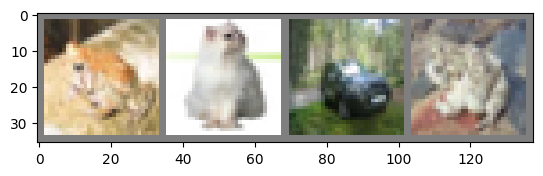

frog  cat   car   frog 


In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 11.7 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 89.3 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 5.9 %
Accuracy for class: horse is 1.8 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


In [ ]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 16.1 MB/s eta 0:00:00


In [ ]:
# ------------------- Preliminaries ------------------- #
import os
from dataclasses import dataclass
from typing import Tuple

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10

# ------------------- Configuration ------------------- #

In [ ]:
@dataclass
class Config:
    """Configuration options for the Lightning MNIST example.

    Args:
        data_dir : The path to the directory where the MNIST dataset is stored. Defaults to the value of
            the 'PATH_DATASETS' environment variable or '.' if not set.

        save_dir : The path to the directory where the training logs will be saved. Defaults to 'logs/'.

        batch_size : The batch size to use during training. Defaults to 256 if a GPU is available,
            or 64 otherwise.

        max_epochs : The maximum number of epochs to train the model for. Defaults to 3.

        accelerator : The accelerator to use for training. Can be one of "cpu", "gpu", "tpu", "ipu", "auto".

        devices : The number of devices to use for training. Defaults to 1.

    Examples:
        This dataclass can be used to specify the configuration options for training a PyTorch Lightning model on the
        MNIST dataset. A new instance of this dataclass can be created as follows:

        >>> config = Config()

        The default values for each argument are shown in the documentation above. If desired, any of these values can be
        overridden when creating a new instance of the dataclass:

        >>> config = Config(batch_size=128, max_epochs=5)
    """

    data_dir: str = os.environ.get("PATH_DATASETS", ".")
    save_dir: str = "logs/"
    batch_size: int = 256 if torch.cuda.is_available() else 4
    max_epochs: int = 3
    accelerator: str = "auto"
    devices: int = 1


config = Config()

In [ ]:

class LitMNIST(L.LightningModule):
    """PyTorch Lightning module for training a multi-layer perceptron (MLP) on the MNIST dataset.

    Attributes:
        data_dir : The path to the directory where the MNIST data will be downloaded.

        hidden_size : The number of units in the hidden layer of the MLP.

        learning_rate : The learning rate to use for training the MLP.

    Methods:
        forward(x):
            Performs a forward pass through the MLP.

        training_step(batch, batch_idx):
            Defines a single training step for the MLP.

        validation_step(batch, batch_idx):
            Defines a single validation step for the MLP.

        test_step(batch, batch_idx):
            Defines a single testing step for the MLP.

        configure_optimizers():
            Configures the optimizer to use for training the MLP.

        prepare_data():
            Downloads the MNIST dataset.

        setup(stage=None):
            Splits the MNIST dataset into train, validation, and test sets.

        train_dataloader():
            Returns a DataLoader for the training set.

        val_dataloader():
            Returns a DataLoader for the validation set.

        test_dataloader():
            Returns a DataLoader for the test set.
    """

    def __init__(self, data_dir: str = config.data_dir, hidden_size: int = 64, learning_rate: float = 2e-4):
        """Initializes a new instance of the LitMNIST class.

        Args:
            data_dir : The path to the directory where the MNIST data will be downloaded. Defaults to config.data_dir.

            hidden_size : The number of units in the hidden layer of the MLP (default is 64).

            learning_rate : The learning rate to use for training the MLP (default is 2e-4).
        """
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 32, 32)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        # Define PyTorch model
        self.criterion = nn.CrossEntropyLoss()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        '''
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.Linear(16 * 5 * 5, 120),
            nn.Linear(120, 84),
            nn.Linear(84, 10)
            ''
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
            ''
        )
        '''

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs a forward pass through the MLP.

        Args:
            x : The input data.

        Returns:
            torch.Tensor: The output of the MLP.
        """
        '''
        x = self.model(x)
        return F.log_softmax(x, dim=1)
        '''
        print("AAAAAAAAAAAA:", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        print("BBBBBBBBBBB:", x.shape)
        return x


    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> torch.Tensor:
        """Defines a single training step for the MLP.

        Args:
            batch: A tuple containing the input data and target labels.

            batch_idx: The index of the current batch.

        Returns:
            (torch.Tensor): The training loss.
        """
        x, y = batch
        logits = self(x)
        #loss = F.nll_loss(logits, y)
        loss = self.criterion(logits, y)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        """Defines a single validation step for the MLP.

        Args:
            batch : A tuple containing the input data and target labels.
            batch_idx : The index of the current batch.
        """
        x, y = batch
        logits = self(x)
        #loss = F.nll_loss(logits, y)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        """Defines a single testing step for the MLP.

        Args:
            batch : A tuple containing the input data and target labels.
            batch_idx : The index of the current batch.
        """
        x, y = batch
        logits = self(x)
        #loss = F.nll_loss(logits, y)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Configures the optimizer to use for training the MLP.

        Returns:
            torch.optim.Optimizer: The optimizer.
        """
        #optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

    # ------------------------------------- #
    # DATA RELATED HOOKS
    # ------------------------------------- #

    def prepare_data(self) -> None:
        """Downloads the MNIST dataset."""
        #MNIST(self.data_dir, train=True, download=True)

        #MNIST(self.data_dir, train=False, download=True)
        CIFAR10(self.data_dir, train=True, download=True)

        CIFAR10(self.data_dir, train=False, download=True)


    def setup(self, stage: str = None) -> None:
        """Splits the MNIST dataset into train, validation, and test sets.

        Args:
            stage : The current stage (either "fit" or "test"). Defaults to None.
        """
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            #mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            mnist_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            print(len(mnist_full))
            self.mnist_train, self.mnist_val = random_split(mnist_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the training set.

        Returns:
            DataLoader: The training DataLoader.
        """
        return DataLoader(self.mnist_train, batch_size=config.batch_size,
                                          shuffle=True, num_workers=2)

    def val_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the validation set.

        Returns:
            DataLoader: The validation DataLoader.
        """
        return DataLoader(self.mnist_val, batch_size=config.batch_size,
                                          shuffle=True, num_workers=2)

    def test_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the test set.

        Returns:
            DataLoader: The test DataLoader.
        """
        return DataLoader(self.mnist_test, batch_size=config.batch_size,
                                         shuffle=False, num_workers=2)


# %%
# Instantiate the LitMNIST model
model = LitMNIST()

# Instantiate a PyTorch Lightning trainer with the specified configuration
trainer = L.Trainer(
    accelerator=config.accelerator,
    devices=config.devices,
    max_epochs=config.max_epochs,
    logger=CSVLogger(save_dir=config.save_dir),
)

# Train the model using the trainer
trainer.fit(model)

'''
# %% [markdown]
# ### Testing
#
# To test a model, call `trainer.test(model)`.
#
# Or, if you've just trained a model, you can just call `trainer.test()` and Lightning will automatically
# test using the best saved checkpoint (conditioned on val_loss).

# %%
trainer.test(ckpt_path="best")

# %% [markdown]
# ### Bonus Tip
#
# You can keep calling `trainer.fit(model)` as many times as you'd like to continue training

# %%
trainer.fit(model)
'''

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | CrossEntropyLoss   | 0     
1 | conv1         | Conv2d             | 456   
2 | pool          | MaxPool2d          | 0     
3 | conv2         | Conv2d             | 2.4 K 
4 | fc1           | Linear             | 48.1 K
5 | fc2           | Linear             | 10.2 K
6 | fc3           | Linear             | 850   
7 | val_accuracy  | MulticlassAccuracy | 0     
8 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
-----------------------------------------------------
0 | criterion     | CrossEntropyLoss   | 0     
1 | conv1         | Conv2d             | 456   
2 | pool          | MaxPool2d

50000


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])


Training: |          | 0/? [00:00<?, ?it/s]

AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32])
BBBBBBBBBBB: torch.Size([4, 10])
AAAAAAAAAAAA: torch.Size([4, 3, 32, 32

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


'\n# %% [markdown]\n# ### Testing\n#\n# To test a model, call `trainer.test(model)`.\n#\n# Or, if you\'ve just trained a model, you can just call `trainer.test()` and Lightning will automatically\n# test using the best saved checkpoint (conditioned on val_loss).\n\n# %%\ntrainer.test(ckpt_path="best")\n\n# %% [markdown]\n# ### Bonus Tip\n#\n# You can keep calling `trainer.fit(model)` as many times as you\'d like to continue training\n\n# %%\ntrainer.fit(model)\n'

In [ ]:
# Read in the training metrics from the CSV file generated by the logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Remove the "step" column, which is not needed for our analysis
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace=True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis=1, how="all").head())

# Create a line plot of the training metrics using Seaborn
sn.relplot(data=metrics, kind="line")
